# Making Graphs for Risk Exposures Compared between Scenarios

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 100)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

### Create interactive sim data 
#### Note: I have saved an old version of this data, you can choose to skip this step and just load the dataset below

Limit this to people of more interest (older) and do a small population for a long time since we aren't looking for population level information 

In [2]:
# pip install git+https://github.com/ihmeuw/vivarium_nih_us_cvd.git

In [3]:
pip freeze | grep vivarium

vivarium==2.1.1
vivarium-nih-us-cvd @ git+https://github.com/ihmeuw/vivarium_nih_us_cvd.git@fbc7031bf98e5bf3ad78923c504c14e55ffdc767
vivarium-public-health==2.1.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
import vivarium_nih_us_cvd
# model_specifications/model_spec.yaml is the typical location within the engineering repo for the
# default spec to live. Ask the engineers if you can't find it.
path = Path(vivarium_nih_us_cvd.__file__.replace('__init__.py', 'model_specifications/nih_us_cvd.yaml'))

from vivarium.framework.configuration import build_model_specification

custom_model_specification = build_model_specification(path)

# Customizations: will be specific to your model and use case!
# Delete observer configuration
del custom_model_specification.configuration.observers
# Change population size
custom_model_specification.configuration.population.population_size = 50_000

# Delete the "metrics" component (an observer)
del custom_model_specification.components.vivarium_public_health.metrics

## Filter out components with 'Observer' or 'Stratifier' in the name
custom_model_specification.components.vivarium_nih_us_cvd.components = [
    c for c in custom_model_specification.components.vivarium_nih_us_cvd.components
    if 'Observer' not in c and 'Stratifier' not in c
]

## This section is specific to the CVD sim and not needed for other interactive sims! 
custom_model_specification.configuration.update({'input_data': {'input_draw_number': 829, 'artifact_path': '/mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/artifacts/51-locations/v4-20231218/florida.hdf'}})

## Changing the interventions to scale up immediately 
custom_model_specification.configuration.intervention.scenario = 'lifestyle_100'
custom_model_specification.configuration.outreach_scale_up.date.start.year = 2021
custom_model_specification.configuration.outreach_scale_up.date.end.year = 2022
custom_model_specification.configuration.outreach_scale_up.value.start = 0
custom_model_specification.configuration.outreach_scale_up.value.end = 0

custom_model_specification.configuration.lifestyle_scale_up.date.start.year = 2021
custom_model_specification.configuration.lifestyle_scale_up.date.end.year = 2022
custom_model_specification.configuration.lifestyle_scale_up.value.start = 0.0855
custom_model_specification.configuration.lifestyle_scale_up.value.end = 1

custom_model_specification.configuration.polypill_scale_up.date.start.year = 2021
custom_model_specification.configuration.polypill_scale_up.date.end.year = 2022
custom_model_specification.configuration.polypill_scale_up.value.start = 0
custom_model_specification.configuration.polypill_scale_up.value.end = 0

In [5]:
sim = InteractiveContext(custom_model_specification)

2024-01-29 17:49:39.946 | INFO     | simulation_1-artifact_manager:67 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/artifacts/51-locations/v4-20231218/florida.hdf.
2024-01-29 17:49:39.949 | INFO     | simulation_1-artifact_manager:68 - Artifact base filter terms are ['draw == 829'].
2024-01-29 17:49:39.951 | INFO     | simulation_1-artifact_manager:69 - Artifact additional filter terms are None.
2024-01-29 17:51:18.954 | WARNING  | simulation_1-values_manager:279 - Unsourced pipelines: ['disability_weight']
2024-01-29 17:51:18.963 | WARNING  | simulation_1-resource_manager:256 - Resource missing_value_source.disability_weight is not provided by any component but is needed to compute (value.disability_weight).


In [6]:
pop0 = sim.get_population()
#pop0

In [7]:
#sim.list_values()

In [8]:
sim_data = pd.DataFrame()
for step in list(range(0,12)):
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                      ], axis=1)
    data_t['step'] = step
    sim_data = pd.concat([sim_data, data_t])
    print(step)

0
1
2
3
4
5
6
7
8
9
10
11


In [9]:
sim_data.outreach.unique()

array(['cat2'], dtype=object)

In [10]:
#sim_data.to_csv('/ihme/homes/lutzes/risk_exposure_baseline_1_29_24_florida.csv')
#sim_data.to_csv('/ihme/homes/lutzes/risk_exposure_polypill_1_29_24_florida.csv')
#sim_data.to_csv('/ihme/homes/lutzes/risk_exposure_outreach_1_29_24_florida.csv')
sim_data.to_csv('/ihme/homes/lutzes/risk_exposure_lifestyle_1_29_24_florida.csv')

## Analyze Data and Set Up for Graphing 

In [2]:
full_data = pd.read_csv('/ihme/homes/lutzes/risk_exposure_baseline_1_29_24_florida.csv')
full_data_polypill = pd.read_csv('/ihme/homes/lutzes/risk_exposure_polypill_1_29_24_florida.csv')
full_data_outreach = pd.read_csv('/ihme/homes/lutzes/risk_exposure_outreach_1_29_24_florida.csv')
full_data_lifestyle = pd.read_csv('/ihme/homes/lutzes/risk_exposure_lifestyle_1_29_24_florida.csv')

full_data.head()

/tmp/ipykernel_1769922/1820219805.py:1: DtypeWarning: Columns (28,39,46,56) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv('/ihme/homes/lutzes/risk_exposure_baseline_1_29_24_florida.csv')
/tmp/ipykernel_1769922/1820219805.py:2: DtypeWarning: Columns (27,40,45,57) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data_polypill = pd.read_csv('/ihme/homes/lutzes/risk_exposure_polypill_1_29_24_florida.csv')
/tmp/ipykernel_1769922/1820219805.py:3: DtypeWarning: Columns (27,39,45,58) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data_outreach = pd.read_csv('/ihme/homes/lutzes/risk_exposure_outreach_1_29_24_florida.csv')
/tmp/ipykernel_1769922/1820219805.py:4: DtypeWarning: Columns (27,40,46,56) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data_lifestyle = pd.read_csv('/ihme/homes/lutzes/risk_exposure_lifestyle_1_29_24_florida.csv')


,Unnamed: 0,tracked,location,age,entrance_time,exit_time,sex,alive,years_of_life_lost,cause_of_death,...,sbp_multiplier,ldlc_multiplier,visit_type,last_fpg_test_date,scheduled_date,high_ldl,high_sbp,high_bmi,high_fpg,step
0,0,True,Florida,52.494371,2020-12-04,NaN,Female,alive,0.0,not_dead,...,1.00,1.000,background,2021-01-01 00:00:00.000000000,NaN,4.263727,100.695191,32.080227,4.105545,0
1,1,True,Florida,41.634539,2020-12-04,NaN,Male,alive,0.0,not_dead,...,1.00,1.000,none,2020-05-17 14:53:04.920631380,NaN,4.496967,100.308361,32.426303,4.666327,0
2,2,True,Florida,58.214433,2020-12-04,NaN,Female,alive,0.0,not_dead,...,1.00,1.000,none,NaN,NaN,4.551611,100.105483,32.236188,5.503998,0
3,3,True,Florida,35.535186,2020-12-04,NaN,Male,alive,0.0,not_dead,...,1.00,1.000,none,2018-09-04 18:27:34.003442544,NaN,4.083885,103.625383,33.151838,4.852161,0
4,4,True,Florida,19.632879,2020-12-04,NaN,Female,alive,0.0,not_dead,...,1.12,1.362,none,NaN,NaN,0.000000,47.400000,5.000000,1.000000,0


In [3]:
def data_processing(data):
    test_data = data.loc[(data.age > 25)]
    test_data['age_start'] = ((test_data.age/5).astype(int) * 5).astype(float)
    test_data = test_data.rename(columns={'Unnamed: 0':'sim_id'})
    test_data = test_data.loc[test_data.step == 11]
    return test_data

In [4]:
test_data = data_processing(full_data)
test_data_polypill = data_processing(full_data_polypill)
test_data_outreach = data_processing(full_data_outreach)
test_data_lifestyle = data_processing(full_data_lifestyle)

In [5]:
polypill_small = test_data_polypill.loc[test_data_polypill.polypill == 'cat1']
sim_id_list = polypill_small.sim_id.unique()
baseline_polypill = test_data.loc[test_data.sim_id.isin(sim_id_list)]
#baseline_polypill.head()

In [6]:
outreach_small = test_data_outreach.loc[test_data_outreach.outreach == 'cat1']
sim_id_list = outreach_small.sim_id.unique()
baseline_outreach = test_data.loc[test_data.sim_id.isin(sim_id_list)]
#baseline_outreach_test = baseline_outreach
#outreach_small_test = outreach_small
#baseline_outreach.head()

In [7]:
outreach_small_test = outreach_small.loc[(outreach_small['ldlc_medication_adherence'] != baseline_outreach['ldlc_medication_adherence'])]
#outreach_small_test = baseline_outreach.loc[(baseline_outreach['ldlc_medication_adherence'] == 'cat1')]
sim_id_list = outreach_small_test.sim_id.unique()
baseline_outreach_test = test_data.loc[test_data.sim_id.isin(sim_id_list)]
len(baseline_outreach_test)

1535

In [8]:
lifestyle_small = test_data_lifestyle[~test_data_lifestyle['lifestyle'].isna()]
sim_id_list = lifestyle_small.sim_id.unique()
baseline_lifestyle = test_data.loc[test_data.sim_id.isin(sim_id_list)]
#baseline_lifestyle.head()

In [9]:
baseline_polypill.high_sbp.mean() - polypill_small.high_sbp.mean()

8.620087019579415

In [10]:
baseline_outreach_test.high_sbp.mean() - outreach_small_test.high_sbp.mean()

0.41967426710093036

In [11]:
baseline_outreach_test.high_ldl.mean() - outreach_small_test.high_ldl.mean()

0.3355512608963007

In [12]:
baseline_lifestyle.high_fpg.mean() - lifestyle_small.high_fpg.mean()

0.14806629834254093

In [13]:
baseline_lifestyle.high_bmi.mean() - lifestyle_small.high_bmi.mean()

1.2289502762430935

In [14]:
len(polypill_small)/len(lifestyle_small)

3.8093922651933703

In [15]:
len(polypill_small)/len(outreach_small_test)

2.695114006514658

In [16]:
len(lifestyle_small)/len(test_data_lifestyle)

0.028212188912557803

In [17]:
len(polypill_small)/len(test_data_polypill)

0.10747129422767185

In [19]:
len(outreach_small_test)/len(test_data_outreach)

0.03987634436535564

## Risk Comparison Graphs

In [20]:
from textwrap import wrap

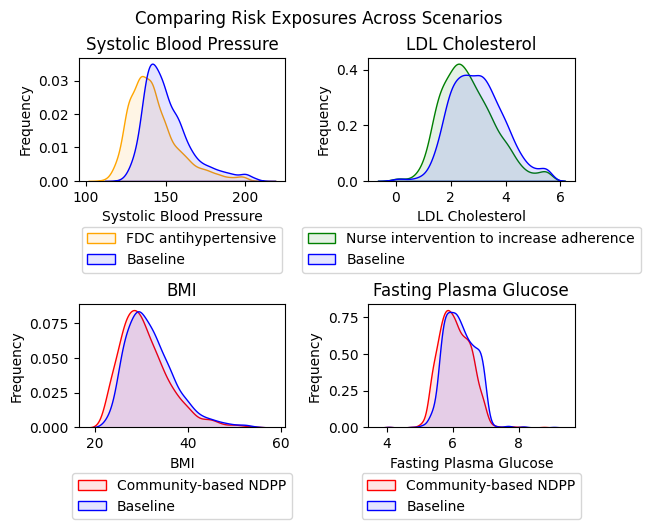

In [21]:
## Add in other interventions 
with PdfPages('florida_risk_exposure_histogram_1_30_24.pdf') as pdf:
    fig = plt.figure()
    fig.subplots_adjust(hspace=1, wspace=0.4)
    plt.suptitle(f'Comparing Risk Exposures Across Scenarios')
    ax = fig.add_subplot(2, 2, 1)
    
    sns.kdeplot(data=polypill_small, x='high_sbp', label='FDC antihypertensive', color = 'orange', alpha = 0.1, fill = True, ax=ax)
    sns.kdeplot(data=baseline_polypill, x='high_sbp', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
    
    ax.set_xlabel('Systolic Blood Pressure')
    ax.set_ylabel('Frequency')
    ax.set_title('Systolic Blood Pressure')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.8))
    
    
    ax = fig.add_subplot(2, 2, 2)
    sns.kdeplot(data=outreach_small_test, x='high_ldl', label='Nurse intervention to increase adherence', color = 'green', alpha = 0.1, fill = True, ax=ax)
    sns.kdeplot(data=baseline_outreach_test, x='high_ldl', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
    
    ax.set_xlabel('LDL Cholesterol')
    ax.set_ylabel('Frequency')
    ax.set_title('LDL Cholesterol')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.8))
    
    
    ax = fig.add_subplot(2, 2, 3)
    sns.kdeplot(data=lifestyle_small, x='high_bmi', label='Community-based NDPP', color = 'red', alpha = 0.1, fill = True, ax=ax)
    sns.kdeplot(data=baseline_lifestyle, x='high_bmi', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
    
    ax.set_xlabel('BMI')
    ax.set_ylabel('Frequency')
    ax.set_title('BMI')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.8))
    
    ax = fig.add_subplot(2, 2, 4)
    sns.kdeplot(data=lifestyle_small, x='high_fpg', label='Community-based NDPP', color = 'red', alpha = 0.1, fill = True, ax=ax)
    sns.kdeplot(data=baseline_lifestyle, x='high_fpg', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
    
    ax.set_xlabel('Fasting Plasma Glucose')
    ax.set_ylabel('Frequency')
    ax.set_title('Fasting Plasma Glucose')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.8))
    pdf.savefig(bbox_inches='tight')

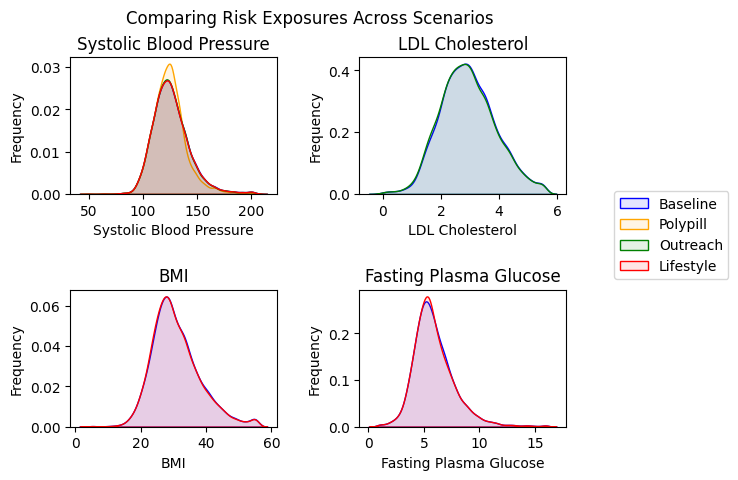

In [16]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.7, wspace=0.4)
plt.suptitle(f'Comparing Risk Exposures Across Scenarios')
ax = fig.add_subplot(2, 2, 1)

sns.kdeplot(data=test_data, x='high_sbp', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_polypill, x='high_sbp', label='Polypill', color = 'orange', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_outreach, x='high_sbp', label='Outreach', color = 'green', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_lifestyle, x='high_sbp', label='Lifestyle', color = 'red', alpha = 0.1, fill = True, ax=ax)

ax.set_xlabel('Systolic Blood Pressure')
ax.set_ylabel('Frequency')
ax.set_title('Systolic Blood Pressure')
plt.legend(loc='center left', bbox_to_anchor=(2.6, -0.3))


ax = fig.add_subplot(2, 2, 2)
sns.kdeplot(data=test_data, x='high_ldl', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_outreach, x='high_ldl', label='Outreach', color = 'green', alpha = 0.1, fill = True, ax=ax)

ax.set_xlabel('LDL Cholesterol')
ax.set_ylabel('Frequency')
ax.set_title('LDL Cholesterol')


ax = fig.add_subplot(2, 2, 3)
sns.kdeplot(data=test_data, x='high_bmi', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_lifestyle, x='high_bmi', label='Lifestyle', color = 'red', alpha = 0.1, fill = True, ax=ax)

ax.set_xlabel('BMI')
ax.set_ylabel('Frequency')
ax.set_title('BMI')


ax = fig.add_subplot(2, 2, 4)
sns.kdeplot(data=test_data, x='high_fpg', label='Baseline', color = 'blue', alpha = 0.1, fill = True, ax=ax)
sns.kdeplot(data=test_data_lifestyle, x='high_fpg', label='Lifestyle', color = 'red', alpha = 0.1, fill = True, ax=ax)

ax.set_xlabel('Fasting Plasma Glucose')
ax.set_ylabel('Frequency')
ax.set_title('Fasting Plasma Glucose')

plt.show()